In [ ]:
import re
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import NearestNeighbors
from scipy.stats import wasserstein_distance

In [ ]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [ ]:
# ------------------ PARSING FUNCTION ------------------ #
def clean_procname(raw):
    """Clean trailing symbols from procname like [ or quotes"""
    return re.sub(r'[\[\]"]+', '', raw)

def parse_log_line(line):
    # Primary pattern to extract timestamp, time_elapsed, host, event_name
    head_pattern = re.compile(
        r"\[(?P<timestamp>[\d:.]+)\] "
        r"\(\+(?P<time_elapsed>[\d.]+)\) "
        r"(?P<host_name>\w+) "
        r"(?P<event_name>[\w_]+):"
    )

    match = head_pattern.match(line)
    if not match:
        return None
    gd = match.groupdict()

    # Extract the rest after matched header
    rest = line[match.end():].strip()

    # Extract cpu_id from first group
    cpu_match = re.search(r"\{ cpu_id = (?P<cpu_id>\d+) \}", rest)
    cpu_id = int(cpu_match.group("cpu_id")) if cpu_match else None

    # Extract procname, pid, tid
    proc_match = re.search(r'\{ procname = "(?P<procname>[^"]+)", pid = (?P<pid>\d+), tid = (?P<tid>\d+)', rest)
    if proc_match:
        procname = clean_procname(proc_match.group("procname"))
        process_details = f'pid = {proc_match.group("pid")}, tid = {proc_match.group("tid")}'
    else:
        procname = None
        process_details = None

    # Extract kernel_details: use the last curly-braced group
    kernel_groups = re.findall(r"\{ ([^{}]+) \}", rest)
    kernel_details = kernel_groups[-1] if kernel_groups else None

    return {
        "timestamp": gd["timestamp"],
        "time_elapsed": gd["time_elapsed"],
        "host_name": gd["host_name"],
        "event_name": gd["event_name"],
        "cpu_id": cpu_id,
        "procname": procname,
        "process_details": process_details,
        "kernel_details": kernel_details
    }

def parse_log_file(file_path):
    parsed_rows = []
    with open(file_path) as f:
        for line in f:
            row = parse_log_line(line)
            if row:
                parsed_rows.append(row)
    return pd.DataFrame(parsed_rows)

# ------------------ DATA LOADING ------------------ #
real_df = parse_log_file("kernel_trace_100K.txt")

In [ ]:
real_df

,timestamp,time_elapsed,host_name,event_name,cpu_id,procname,process_details,kernel_details
0,06:13:02.227912438,0.000003750,mendax,syscall_exit_accept,2,elasticsearchm,"pid = 11822, tid = 11859","ret = 576, upeer_sockaddr = 246916502706648, u..."
1,06:13:02.227914646,0.000002208,mendax,syscall_entry_fcntl,2,elasticsearchm,"pid = 11822, tid = 11859","fd = 576, cmd = 3, arg = 50"
2,06:13:02.227914980,0.000000334,mendax,syscall_exit_fcntl,2,elasticsearchm,"pid = 11822, tid = 11859","ret = 2, arg = 50"
3,06:13:02.227916313,0.000001333,mendax,syscall_entry_getsockname,2,elasticsearchm,"pid = 11822, tid = 11859","fd = 576, usockaddr_len = 246916502706368"
4,06:13:02.227916771,0.000000458,mendax,syscall_exit_getsockname,2,elasticsearchm,"pid = 11822, tid = 11859","ret = 0, usockaddr = 246916502706376, usockadd..."
...,...,...,...,...,...,...,...,...
99994,06:13:09.322503258,0.000001334,mendax,syscall_exit_epoll_pwait,1,Mutter Input Th,"pid = 3154, tid = 3269","EPOLLIN = 1, EPOLLPRI = 0, EPOLLOUT = 0, EPOLL..."
99995,06:13:09.322504341,0.000001083,mendax,syscall_entry_read,1,Mutter Input Th,"pid = 3154, tid = 3269","fd = 27, count = 6144"
99996,06:13:09.322506008,0.000001667,mendax,syscall_exit_read,1,Mutter Input Th,"pid = 3154, tid = 3269","ret = 72, buf = 248271726143264"
99997,06:13:09.322507716,0.000001708,mendax,syscall_entry_read,1,Mutter Input Th,"pid = 3154, tid = 3269","fd = 27, count = 6144"


In [ ]:
lstm = real_df.copy(deep=True)

In [ ]:
lstm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   timestamp        99999 non-null  object
 1   time_elapsed     99999 non-null  object
 2   host_name        99999 non-null  object
 3   event_name       99999 non-null  object
 4   cpu_id           99999 non-null  int64 
 5   procname         99999 non-null  object
 6   process_details  99999 non-null  object
 7   kernel_details   99999 non-null  object
dtypes: int64(1), object(7)
memory usage: 6.1+ MB


In [ ]:
numerical_cols = ['time_elapsed', 'cpu_id']
categorical_cols = ['timestamp', 'host_name', 'event_name', 'procname', 'process_details', 'kernel_details']

<Axes: >

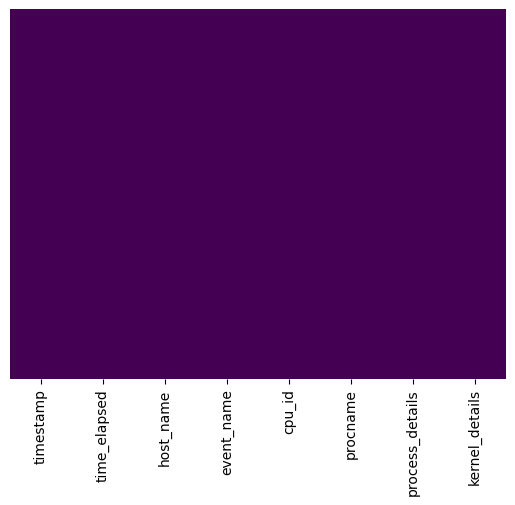

In [ ]:
sns.heatmap(lstm.isnull(), yticklabels=False, cbar=False, cmap='viridis') # shows if any null value rows exists in the dataset

In [ ]:
lstm

,timestamp,time_elapsed,host_name,event_name,cpu_id,procname,process_details,kernel_details
0,06:13:02.227912438,0.000003750,mendax,syscall_exit_accept,2,elasticsearchm,"pid = 11822, tid = 11859","ret = 576, upeer_sockaddr = 246916502706648, u..."
1,06:13:02.227914646,0.000002208,mendax,syscall_entry_fcntl,2,elasticsearchm,"pid = 11822, tid = 11859","fd = 576, cmd = 3, arg = 50"
2,06:13:02.227914980,0.000000334,mendax,syscall_exit_fcntl,2,elasticsearchm,"pid = 11822, tid = 11859","ret = 2, arg = 50"
3,06:13:02.227916313,0.000001333,mendax,syscall_entry_getsockname,2,elasticsearchm,"pid = 11822, tid = 11859","fd = 576, usockaddr_len = 246916502706368"
4,06:13:02.227916771,0.000000458,mendax,syscall_exit_getsockname,2,elasticsearchm,"pid = 11822, tid = 11859","ret = 0, usockaddr = 246916502706376, usockadd..."
...,...,...,...,...,...,...,...,...
99994,06:13:09.322503258,0.000001334,mendax,syscall_exit_epoll_pwait,1,Mutter Input Th,"pid = 3154, tid = 3269","EPOLLIN = 1, EPOLLPRI = 0, EPOLLOUT = 0, EPOLL..."
99995,06:13:09.322504341,0.000001083,mendax,syscall_entry_read,1,Mutter Input Th,"pid = 3154, tid = 3269","fd = 27, count = 6144"
99996,06:13:09.322506008,0.000001667,mendax,syscall_exit_read,1,Mutter Input Th,"pid = 3154, tid = 3269","ret = 72, buf = 248271726143264"
99997,06:13:09.322507716,0.000001708,mendax,syscall_entry_read,1,Mutter Input Th,"pid = 3154, tid = 3269","fd = 27, count = 6144"


In [ ]:
original_categoricals = lstm[categorical_cols].copy()

In [ ]:
# Encode categorical "event" type to integer
for col in categorical_cols:
    le = LabelEncoder()
    lstm[col] = le.fit_transform(lstm[col].astype(str))

In [ ]:
lstm.head(1000)

,timestamp,time_elapsed,host_name,event_name,cpu_id,procname,process_details,kernel_details
0,0,0.000003750,0,76,2,32,25,8160
1,1,0.000002208,0,16,2,32,25,4441
2,2,0.000000334,0,90,2,32,25,7755
3,3,0.000001333,0,28,2,32,25,4453
4,4,0.000000458,0,102,2,32,25,6350
...,...,...,...,...,...,...,...,...
995,994,0.000000209,0,15,0,48,111,3951
996,995,0.000000833,0,89,0,48,111,5144
997,996,0.000000333,0,33,0,48,111,3911
998,997,0.000000209,0,107,0,48,111,5047


In [ ]:
lstmData = lstm.copy(deep=True)

In [ ]:
lstmData = lstmData.astype('float64')

In [ ]:
lstmData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   timestamp        99999 non-null  float64
 1   time_elapsed     99999 non-null  float64
 2   host_name        99999 non-null  float64
 3   event_name       99999 non-null  float64
 4   cpu_id           99999 non-null  float64
 5   procname         99999 non-null  float64
 6   process_details  99999 non-null  float64
 7   kernel_details   99999 non-null  float64
dtypes: float64(8)
memory usage: 6.1 MB


In [ ]:
lstmValue = lstmData.values
sequence_length = 35
# Creating training data using TimeSeriesGenerator
X, y = [], []
for i in range(len(lstmValue) - sequence_length):
    X.append(lstmValue[i:i + sequence_length])
    y.append(lstmValue[i + sequence_length])

X, y = np.array(X), np.array(y)

In [ ]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.3),
    LSTM(64),
    Dense(64, activation='relu'),
    Dense(y.shape[1])
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
3124/3124 ━━━━━━━━━━━━━━━━━━━━ 241s 75ms/step - loss: 847.0762
Epoch 2/30
3124/3124 ━━━━━━━━━━━━━━━━━━━━ 264s 76ms/step - loss: 889.2153
Epoch 3/30
3124/3124 ━━━━━━━━━━━━━━━━━━━━ 236s 76ms/step - loss: 873.9882
Epoch 4/30
3124/3124 ━━━━━━━━━━━━━━━━━━━━ 260s 75ms/step - loss: 897.3693
Epoch 5/30
3124/3124 ━━━━━━━━━━━━━━━━━━━━ 263s 75ms/step - loss: 877.9402
Epoch 6/30
3124/3124 ━━━━━━━━━━━━━━━━━━━━ 261s 75ms/step - loss: 827.2885
Epoch 7/30
3124/3124 ━━━━━━━━━━━━━━━━━━━━ 264s 76ms/step - loss: 764.4948
Epoch 8/30
3124/3124 ━━━━━━━━━━━━━━━━━━━━ 261s 75ms/step - loss: 757.4038
Epoch 9/30
3124/3124 ━━━━━━━━━━━━━━━━━━━━ 264s 76ms/step - loss: 754.9227
Epoch 10/30
3124/3124 ━━━━━━━━━━━━━━━━━━━━ 259s 75ms/step - loss: 739.2073
Epoch 11/30
3124/3124 ━━━━━━━━━━━━━━━━━━━━ 263s 75ms/step - loss: 784.1376
Epoch 12/30
3124/3124 ━━━━━━━━━━━━━━━━━━━━ 261s 75ms/step - loss: 743.3021
Epoch 13/30
3124/3124 ━━━━━━━━━━━━━━━━━━━━ 235s 75ms/step - loss: 779.0474
Epoch 14/30
3124/3124 ━━━━━━━━━━━━

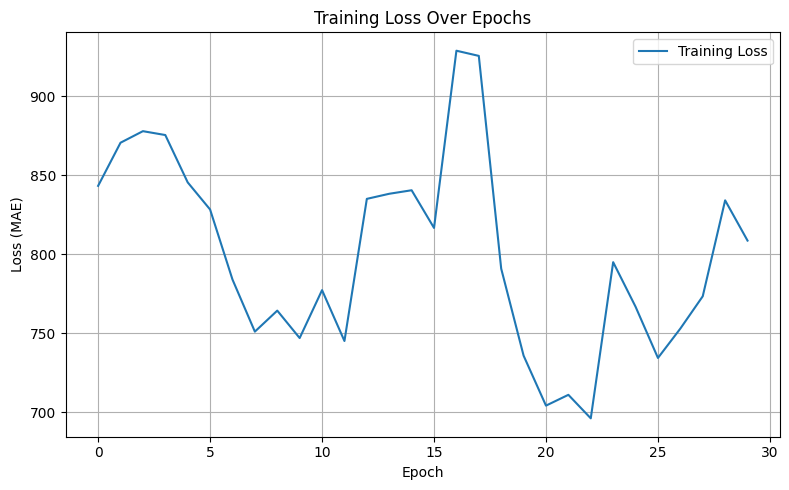

In [ ]:
import matplotlib.pyplot as plt

# Compile model
model.compile(optimizer="adam", loss="mae")

# Train the model and store history
history = model.fit(X, y, epochs=30, batch_size=32)

# Plot training loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Generate new sequence
def generate_synthetic_data(model, seed_data, num_steps=50):
    generated_data = list(seed_data)

    for _ in range(num_steps):
        input_seq = np.array(generated_data[-sequence_length:]).reshape(1, sequence_length, -1)
        predicted = model.predict(input_seq, verbose=0)[0]
        generated_data.append(predicted)

    return np.array(generated_data)

In [ ]:
sequence_length = 35
seed_sequence = lstmValue[-sequence_length:]
encoders = {}
columns = lstmData.columns.tolist()

# Generate synthetic data
synthetic_logs = generate_synthetic_data(model, seed_sequence, num_steps=100000)
synthetic_df = pd.DataFrame(synthetic_logs, columns=columns)
subset_df = real_df

# Fit encoders explicitly on original strings
for col in categorical_cols:
    encoder = LabelEncoder()
    encoder.fit(subset_df[col].astype(str))
    encoders[col] = encoder

# Decode categorical columns explicitly
for col in categorical_cols:
    if col not in synthetic_df.columns:
        continue

    encoder = encoders[col]
    max_index = len(encoder.classes_) - 1

    # Convert entire column explicitly to int and clip BEFORE decoding
    synthetic_df[col] = synthetic_df[col].round().astype(int).clip(0, max_index)
    synthetic_df[col] = encoder.inverse_transform(synthetic_df[col])

# Ensure categorical columns dtype
synthetic_df[categorical_cols] = synthetic_df[categorical_cols].astype('object')

print("\n✅ Corrected Synthetic Logs (Categorical Columns Decoded):")
print(synthetic_df.head())


✅ Corrected Synthetic Logs (Categorical Columns Decoded):
            timestamp  time_elapsed host_name           event_name  cpu_id  \
0  06:13:09.321372956  5.840000e-07    mendax   syscall_exit_futex     3.0   
1  06:13:09.321373331  3.750000e-07    mendax  syscall_entry_futex     3.0   
2  06:13:09.321373456  1.250000e-07    mendax   syscall_exit_futex     3.0   
3  06:13:09.321374414  9.580000e-07    mendax  syscall_entry_futex     3.0   
4  06:13:09.321379372  4.958000e-06    mendax   syscall_exit_futex     0.0   

  procname           process_details  \
0     node  pid = 12061, tid = 12068   
1     node  pid = 12061, tid = 12068   
2     node  pid = 12061, tid = 12068   
3     node  pid = 12061, tid = 12068   
4     node  pid = 12061, tid = 12061   

                                      kernel_details  
0            ret = 0, uaddr = 1151640084, uaddr2 = 0  
1  uaddr = 1151640000, op = 129, val = 1, utime =...  
2            ret = 0, uaddr = 1151640000, uaddr2 = 0  
3  uaddr = 

In [ ]:
real_df

,timestamp,time_elapsed,host_name,event_name,cpu_id,procname,process_details,kernel_details
0,06:13:02.227912438,0.000003750,mendax,syscall_exit_accept,2,elasticsearchm,"pid = 11822, tid = 11859","ret = 576, upeer_sockaddr = 246916502706648, u..."
1,06:13:02.227914646,0.000002208,mendax,syscall_entry_fcntl,2,elasticsearchm,"pid = 11822, tid = 11859","fd = 576, cmd = 3, arg = 50"
2,06:13:02.227914980,0.000000334,mendax,syscall_exit_fcntl,2,elasticsearchm,"pid = 11822, tid = 11859","ret = 2, arg = 50"
3,06:13:02.227916313,0.000001333,mendax,syscall_entry_getsockname,2,elasticsearchm,"pid = 11822, tid = 11859","fd = 576, usockaddr_len = 246916502706368"
4,06:13:02.227916771,0.000000458,mendax,syscall_exit_getsockname,2,elasticsearchm,"pid = 11822, tid = 11859","ret = 0, usockaddr = 246916502706376, usockadd..."
...,...,...,...,...,...,...,...,...
99994,06:13:09.322503258,0.000001334,mendax,syscall_exit_epoll_pwait,1,Mutter Input Th,"pid = 3154, tid = 3269","EPOLLIN = 1, EPOLLPRI = 0, EPOLLOUT = 0, EPOLL..."
99995,06:13:09.322504341,0.000001083,mendax,syscall_entry_read,1,Mutter Input Th,"pid = 3154, tid = 3269","fd = 27, count = 6144"
99996,06:13:09.322506008,0.000001667,mendax,syscall_exit_read,1,Mutter Input Th,"pid = 3154, tid = 3269","ret = 72, buf = 248271726143264"
99997,06:13:09.322507716,0.000001708,mendax,syscall_entry_read,1,Mutter Input Th,"pid = 3154, tid = 3269","fd = 27, count = 6144"


In [ ]:
synthetic_df

,timestamp,time_elapsed,host_name,event_name,cpu_id,procname,process_details,kernel_details
0,06:13:09.321372956,5.840000e-07,mendax,syscall_exit_futex,3.000000,node,"pid = 12061, tid = 12068","ret = 0, uaddr = 1151640084, uaddr2 = 0"
1,06:13:09.321373331,3.750000e-07,mendax,syscall_entry_futex,3.000000,node,"pid = 12061, tid = 12068","uaddr = 1151640000, op = 129, val = 1, utime =..."
2,06:13:09.321373456,1.250000e-07,mendax,syscall_exit_futex,3.000000,node,"pid = 12061, tid = 12068","ret = 0, uaddr = 1151640000, uaddr2 = 0"
3,06:13:09.321374414,9.580000e-07,mendax,syscall_entry_futex,3.000000,node,"pid = 12061, tid = 12068","uaddr = 1151640080, op = 393, val = 4311, utim..."
4,06:13:09.321379372,4.958000e-06,mendax,syscall_exit_futex,0.000000,node,"pid = 12061, tid = 12061","ret = 2, uaddr = 1151736432, uaddr2 = 74"
...,...,...,...,...,...,...,...,...
100030,06:13:08.860598343,-8.346371e-02,mendax,syscall_exit_faccessat,2.885166,ibus-engine-sim,"pid = 3154, tid = 3214","ret = 0, statbuf = 281474473867424"
100031,06:13:08.860598343,-8.346371e-02,mendax,syscall_exit_faccessat,2.885166,ibus-engine-sim,"pid = 3154, tid = 3214","ret = 0, statbuf = 281474473867424"
100032,06:13:08.860598343,-8.346371e-02,mendax,syscall_exit_faccessat,2.885166,ibus-engine-sim,"pid = 3154, tid = 3214","ret = 0, statbuf = 281474473867424"
100033,06:13:08.860598343,-8.346371e-02,mendax,syscall_exit_faccessat,2.885166,ibus-engine-sim,"pid = 3154, tid = 3214","ret = 0, statbuf = 281474473867424"


In [ ]:
synthetic_df['timestamp'] = "'" + synthetic_df['timestamp'].astype(str)
synthetic_df.to_csv("synthetic_linux_logs_100K_LSTM.csv", index=False)

In [ ]:
print("Unique values in 'event':", real_df['event_name'].unique())

Unique values in 'event': ['syscall_exit_accept' 'syscall_entry_fcntl' 'syscall_exit_fcntl'
 'syscall_entry_getsockname' 'syscall_exit_getsockname'
 'syscall_entry_setsockopt' 'syscall_exit_setsockopt'
 'syscall_entry_getsockopt' 'syscall_exit_getsockopt'
 'syscall_entry_write' 'syscall_exit_write' 'syscall_entry_epoll_pwait'
 'syscall_exit_connect' 'syscall_entry_rt_sigaction'
 'syscall_exit_rt_sigaction' 'syscall_entry_ppoll' 'syscall_exit_ppoll'
 'syscall_entry_futex' 'syscall_exit_futex' 'syscall_entry_getpid'
 'syscall_exit_getpid' 'syscall_entry_brk' 'syscall_exit_brk'
 'syscall_entry_getrandom' 'syscall_exit_getrandom' 'syscall_entry_munmap'
 'syscall_exit_munmap' 'syscall_entry_sendto' 'syscall_exit_sendto'
 'syscall_entry_recvfrom' 'syscall_exit_recvfrom'
 'syscall_exit_epoll_pwait' 'syscall_entry_read' 'syscall_exit_read'
 'syscall_entry_epoll_ctl' 'syscall_exit_epoll_ctl' 'syscall_entry_ioctl'
 'syscall_exit_ioctl' 'syscall_entry_close' 'syscall_exit_close'
 'syscall_entry_r

In [ ]:
print("Unique values in 'event':", synthetic_df['event_name'].unique())

Unique values in 'event': ['syscall_exit_futex' 'syscall_entry_futex' 'syscall_entry_getpid'
 'syscall_exit_getpid' 'syscall_exit_ppoll' 'syscall_entry_epoll_pwait'
 'syscall_exit_epoll_pwait' 'syscall_entry_read' 'syscall_exit_read'
 'syscall_exit_connect' 'syscall_exit_dup' 'syscall_exit_close'
 'syscall_exit_clone' 'syscall_exit_clock_gettime'
 'syscall_exit_epoll_ctl' 'syscall_exit_eventfd2' 'syscall_exit_execve'
 'syscall_exit_faccessat']
